In [30]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import warnings, random

warnings.filterwarnings("ignore")


df = pd.read_csv("preprocess/amazon-cleaned.csv")

print("Head of the dataset:")
print(df.head())




Head of the dataset:
   product_id  category  discounted_price  actual_price  rating  rating_count  \
0  B07JW9H4J1       176             399.0        1099.0     4.2       24269.0   
1  B07JW9H4J1       176             399.0        1099.0     4.2       24269.0   
2  B07JW9H4J1       176             399.0        1099.0     4.2       24269.0   
3  B07JW9H4J1       176             399.0        1099.0     4.2       24269.0   
4  B07JW9H4J1       176             399.0        1099.0     4.2       24269.0   

   user_id    review_title                                     review_content  \
0     3624         satisfy  durable charge fine toono complain charge fast...   
1     5045     charge fast  durable charge fine toono complain charge fast...   
2     4093           money  durable charge fine toono complain charge fast...   
3     3813  product review  durable charge fine toono complain charge fast...   
4     7351    good quality  durable charge fine toono complain charge fast...   

   en

## Select numeric features for clustering

In [ ]:
numeric_cols = [
    "category",
    "discounted_price",
    "actual_price",
    "rating",
    "rating_count",
    "encode_review_raing",
]
X = df[numeric_cols].dropna()

print({X.shape[0]})





{11444}


In [32]:
df

,product_id,category,discounted_price,actual_price,rating,rating_count,user_id,review_title,review_content,encode_review_raing
0,B07JW9H4J1,176,399.0,1099.0,4.2,24269.0,3624,satisfy,durable charge fine toono complain charge fast...,2
1,B07JW9H4J1,176,399.0,1099.0,4.2,24269.0,5045,charge fast,durable charge fine toono complain charge fast...,2
2,B07JW9H4J1,176,399.0,1099.0,4.2,24269.0,4093,money,durable charge fine toono complain charge fast...,2
3,B07JW9H4J1,176,399.0,1099.0,4.2,24269.0,3813,product review,durable charge fine toono complain charge fast...,2
4,B07JW9H4J1,176,399.0,1099.0,4.2,24269.0,7351,good quality,durable charge fine toono complain charge fast...,2
...,...,...,...,...,...,...,...,...,...,...
11441,B01486F4G6,134,2863.0,3690.0,4.3,6987.0,8997,excellent product,job perfectly issue temp control perfect check...,2
11442,B01486F4G6,134,2863.0,3690.0,4.3,6987.0,5099,good product household,job perfectly issue temp control perfect check...,2
11443,B01486F4G6,134,2863.0,3690.0,4.3,6987.0,2369,product,job perfectly issue temp control perfect check...,2
11444,B01486F4G6,134,2863.0,3690.0,4.3,6987.0,8151,good,job perfectly issue temp control perfect check...,2


## Standardize features

In [33]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


## Elbow method to inspect inertia

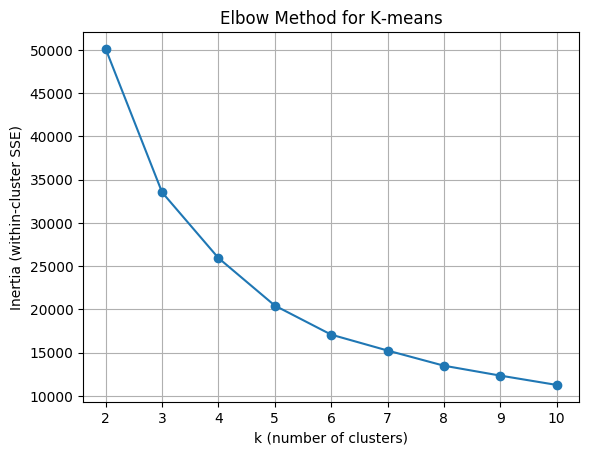

In [34]:

inertias = []
k_range = range(2, 11)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure()
plt.plot(list(k_range), inertias, marker="o")
plt.xlabel("k (number of clusters)")
plt.ylabel("Inertia (within‑cluster SSE)")
plt.title("Elbow Method for K‑means")
plt.grid(True)
plt.show()


## Silhouette scores to gauge cluster quality

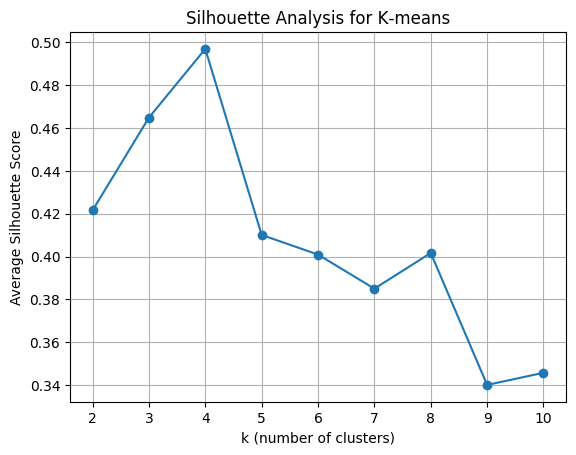

In [35]:
sil_scores = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    sample_idx = np.random.choice(X_scaled.shape[0], min(2000, X_scaled.shape[0]), replace=False)
    sil = silhouette_score(X_scaled[sample_idx], km.labels_[sample_idx])
    sil_scores.append(sil)

plt.figure()
plt.plot(list(k_range), sil_scores, marker="o")
plt.xlabel("k (number of clusters)")
plt.ylabel("Average Silhouette Score")
plt.title("Silhouette Analysis for K‑means")
plt.grid(True)
plt.show()

## Choose the best k (highest silhouette)

In [36]:

best_k = k_range[np.argmax(sil_scores)]
print(f"\nOptimal number of clusters based on silhouette score: k = {best_k}")


Optimal number of clusters based on silhouette score: k = 4


## Fit final KMeans model

In [37]:

final_km = KMeans(n_clusters=best_k, random_state=42, n_init=10)
final_labels = final_km.fit_predict(X_scaled)

## Append cluster labels to the original dataframe

In [38]:

df_clusters = X.copy()
df_clusters["cluster"] = final_labels


## Cluster sizes

In [39]:

cluster_sizes = df_clusters["cluster"].value_counts().sort_index()
print("\nCluster sizes:")
print(cluster_sizes)



Cluster sizes:
cluster
0    7610
1    2701
2     885
3     248
Name: count, dtype: int64


## Cluster centers (inverse‑scaled to original units)

In [40]:

centers_scaled = final_km.cluster_centers_
centers_unscaled = pd.DataFrame(
    scaler.inverse_transform(centers_scaled),
    columns=numeric_cols
)
centers_unscaled["cluster"] = centers_unscaled.index

# Display the cluster centers as an interactive table
print(centers_unscaled.round(2))



   category  discounted_price  actual_price  rating  rating_count  \
0    122.95           1410.25       2869.86    4.22      14456.76   
1    112.06           1413.40       2902.86    3.71       8518.86   
2     17.49          22168.69      33919.26    4.20      16290.45   
3     68.03           1542.61       2474.23    4.19     254213.00   

   encode_review_raing  cluster  
0                 2.00        0  
1                 1.00        1  
2                 1.96        2  
3                 1.97        3  


In [41]:
# 12. Show a sample of points with their assigned cluster
df_clusters.head(20)


,category,discounted_price,actual_price,rating,rating_count,encode_review_raing,cluster
0,176,399.0,1099.0,4.2,24269.0,2,0
1,176,399.0,1099.0,4.2,24269.0,2,0
2,176,399.0,1099.0,4.2,24269.0,2,0
3,176,399.0,1099.0,4.2,24269.0,2,0
4,176,399.0,1099.0,4.2,24269.0,2,0
5,176,399.0,1099.0,4.2,24269.0,2,0
6,176,399.0,1099.0,4.2,24269.0,2,0
7,176,399.0,1099.0,4.2,24269.0,2,0
8,176,199.0,349.0,4.0,43994.0,2,0
9,176,199.0,349.0,4.0,43994.0,2,0
